## Task1：代码复现

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# 忽略警告
warnings.filterwarnings("ignore")
# 正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 正常显示负号
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline

### 数据读取和清洗

In [3]:
df = pd.read_excel('dataset/Carbon_Dioxide_Emissions_From_Energy_Consumption-_Electric_Power_Sector.xlsx', index_col = 'Month')
# 查看数据变量属性
df.info()
# 查看数据前10行
df.head(10)
df.tail(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 576 entries, 1973-01-01 to 2020-12-01
Data columns (total 9 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   Coal Electric Power Sector CO2 Emissions                                                    576 non-null    float64
 1   Natural Gas Electric Power Sector CO2 Emissions                                             576 non-null    float64
 2   Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions  576 non-null    float64
 3   Petroleum Coke Electric Power Sector CO2 Emissions                                          576 non-null    float64
 4   Residual Fuel Oil Electric Power Sector CO2 Emissions                                       576 non-null    float64
 5   Petroleum Electric Power 

,Coal Electric Power Sector CO2 Emissions,Natural Gas Electric Power Sector CO2 Emissions,"Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions",Petroleum Coke Electric Power Sector CO2 Emissions,Residual Fuel Oil Electric Power Sector CO2 Emissions,Petroleum Electric Power Sector CO2 Emissions,Geothermal Energy Electric Power Sector CO2 Emissions,Non-Biomass Waste Electric Power Sector CO2 Emissions,Total Energy Electric Power Sector CO2 Emissions
Month,,,,,,,,,
2020-10-01,61.385,52.159,0.292,0.374,0.396,1.062,0.035,0.904,115.546
2020-11-01,62.245,41.947,0.267,0.604,0.341,1.212,0.034,0.875,106.314
2020-12-01,78.821,47.734,0.319,0.802,0.365,1.486,0.035,0.904,128.981


因为数据有缺失，利用key_list将df分为df1和df2

In [4]:
# 利用key_list 分割data
key_list = ['Geothermal Energy Electric Power Sector CO2 Emissions', 'Non-Biomass Waste Electric Power Sector CO2 Emissions' ]
df1 = df[df.keys().drop(key_list)] # df1为剔除key_list后的数据
df1.head(3)

,Coal Electric Power Sector CO2 Emissions,Natural Gas Electric Power Sector CO2 Emissions,"Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions",Petroleum Coke Electric Power Sector CO2 Emissions,Residual Fuel Oil Electric Power Sector CO2 Emissions,Petroleum Electric Power Sector CO2 Emissions,Total Energy Electric Power Sector CO2 Emissions
Month,,,,,,,
1973-01-01,72.076,12.175,2.375,0.128,24.867,27.369,111.621
1973-02-01,64.442,11.708,2.061,0.106,20.867,23.034,99.185
1973-03-01,64.084,13.994,1.171,0.083,19.780,21.034,99.112


In [5]:
# df2为key_list中的数据
df2 = df[key_list]

# df2删除值为Not Available的行
df2 = df2.drop(df2[df2.values == 'Not Available'].index)
# object类型转换为float类型
df2 = df2.astype(np.float64)

df2.head(3)

,Geothermal Energy Electric Power Sector CO2 Emissions,Non-Biomass Waste Electric Power Sector CO2 Emissions
Month,,
1989-01-01,0.031,0.371
1989-02-01,0.028,0.335
1989-03-01,0.031,0.371


### 可视化处理

有9种CO2排放能源，先绘制CO2排放量折线图

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


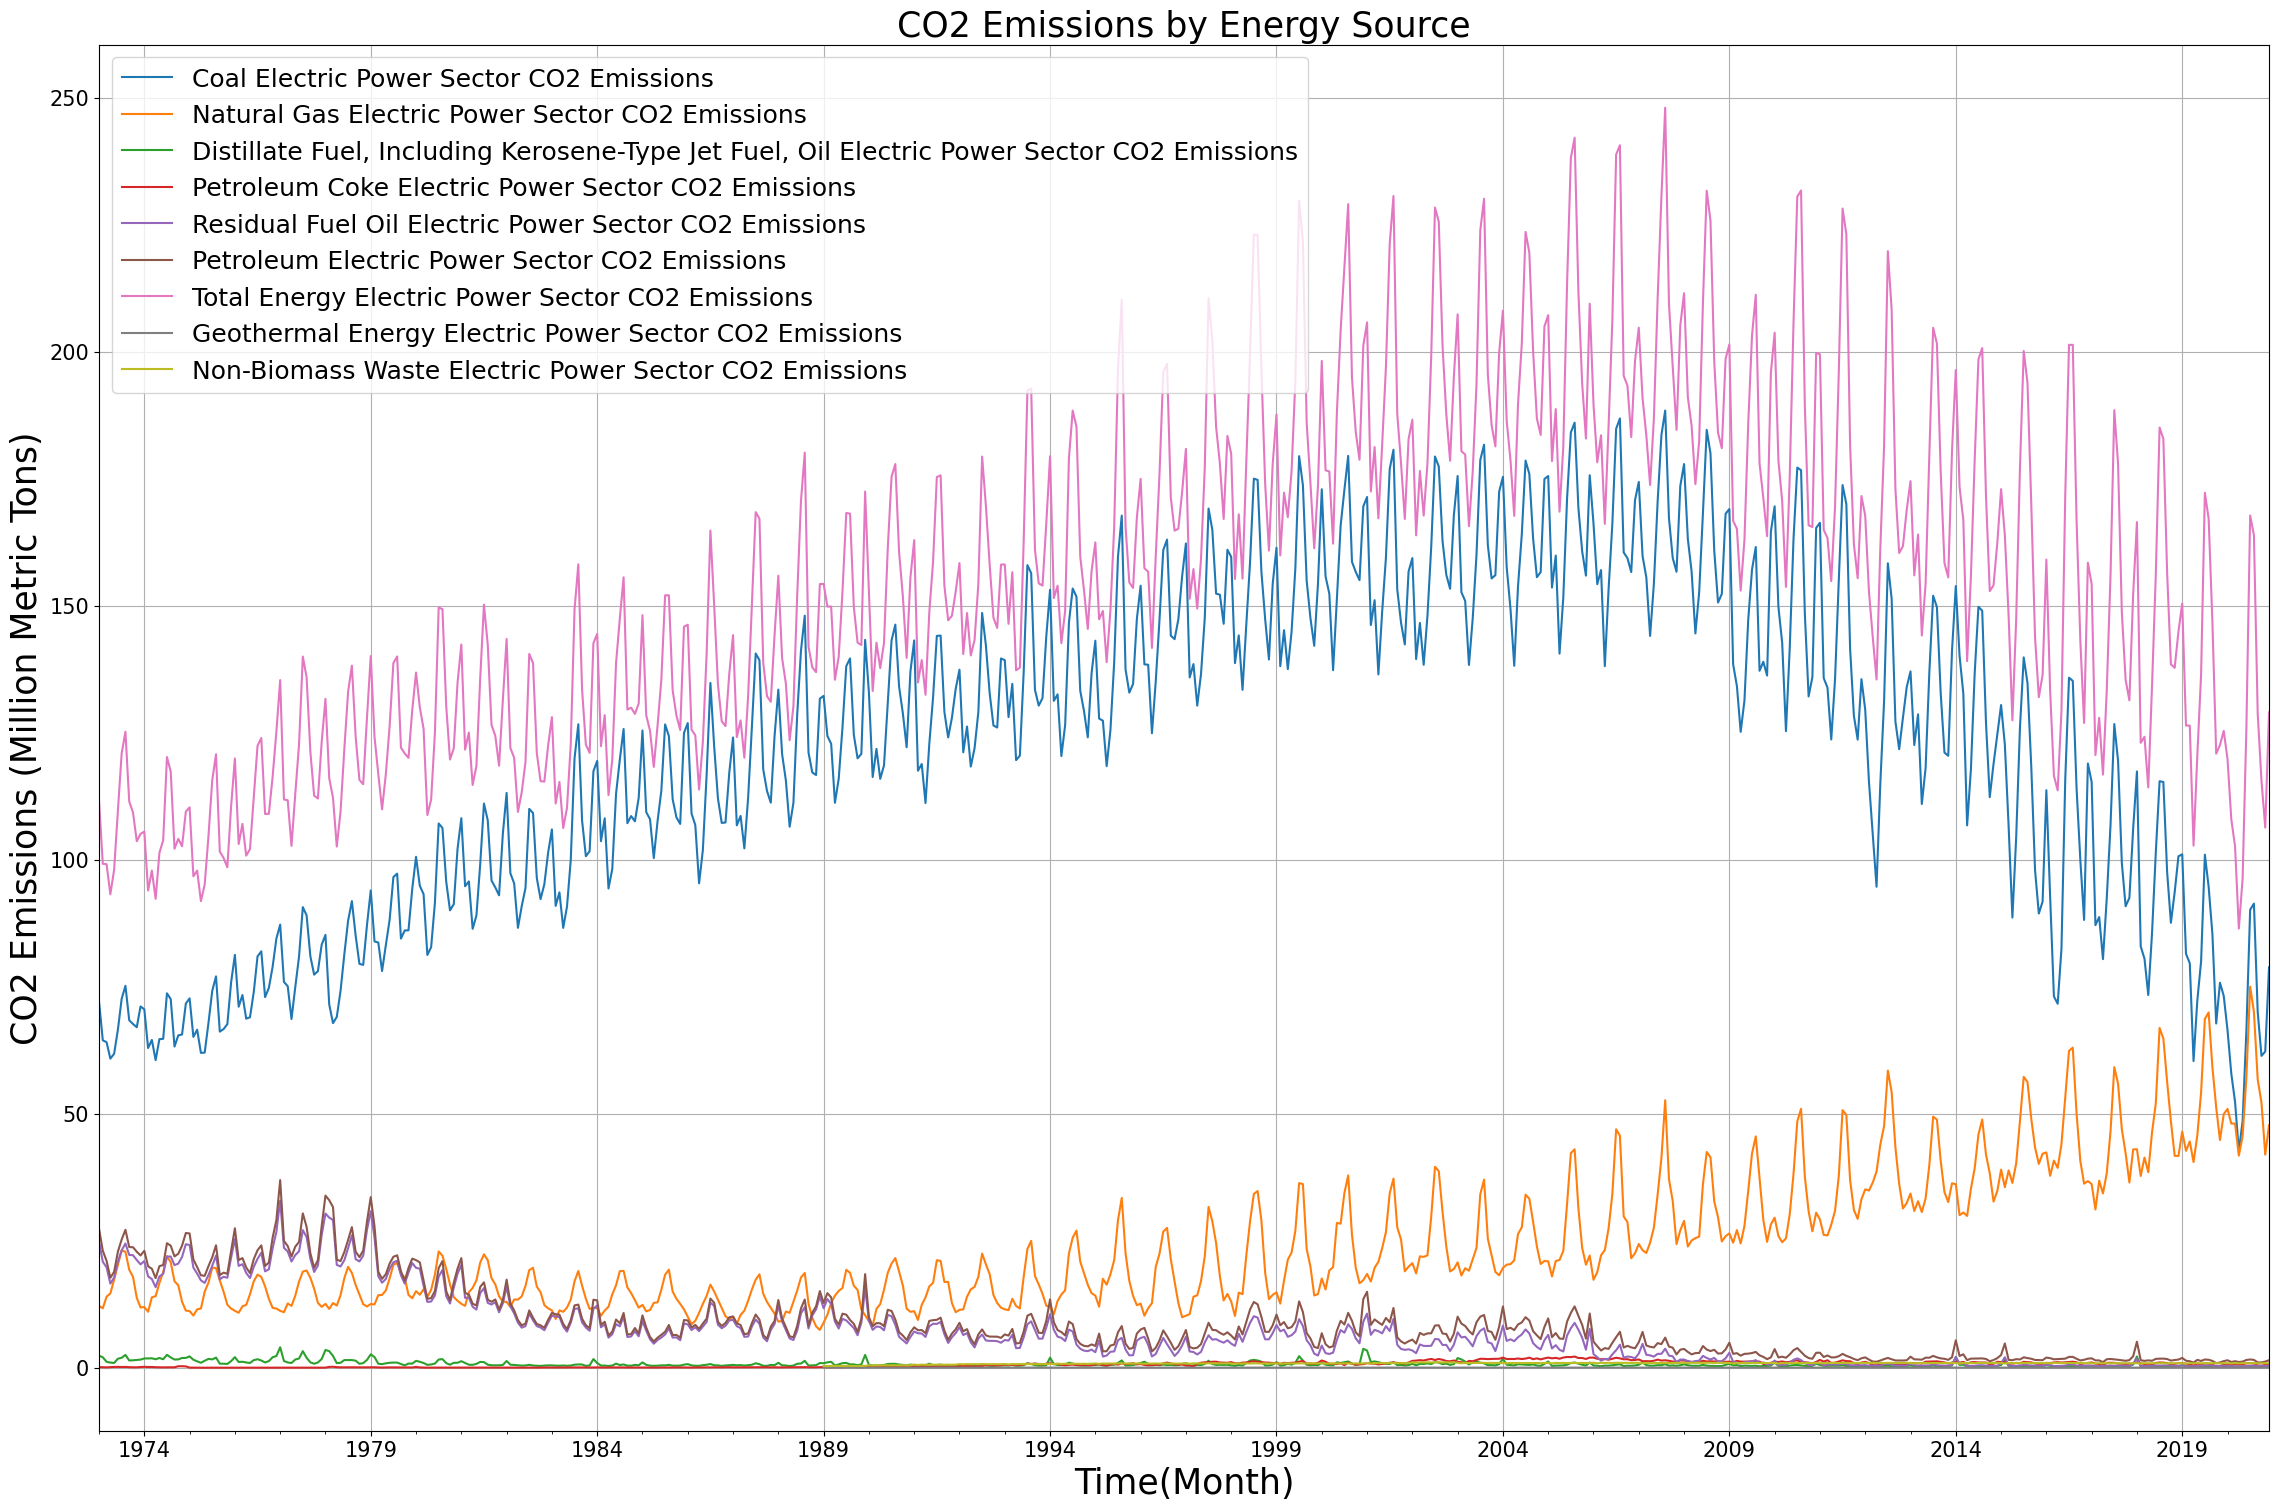

In [6]:
keysl = df1.keys()
fig, ax = plt.subplots(figsize = (28, 18))

df1.plot(ax = ax, fontsize = 15)
df2.plot(ax = ax, fontsize = 15)

# 设置子图
ax.set_title('CO2 Emissions by Energy Source', fontsize = 25)
ax.set_xlabel('Time(Month)', fontsize = 25)
ax.set_ylabel('CO2 Emissions (Million Metric Tons)', fontsize = 25)
ax.legend(loc='best', fontsize = 18)
ax.grid()

以子图的形式绘制

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


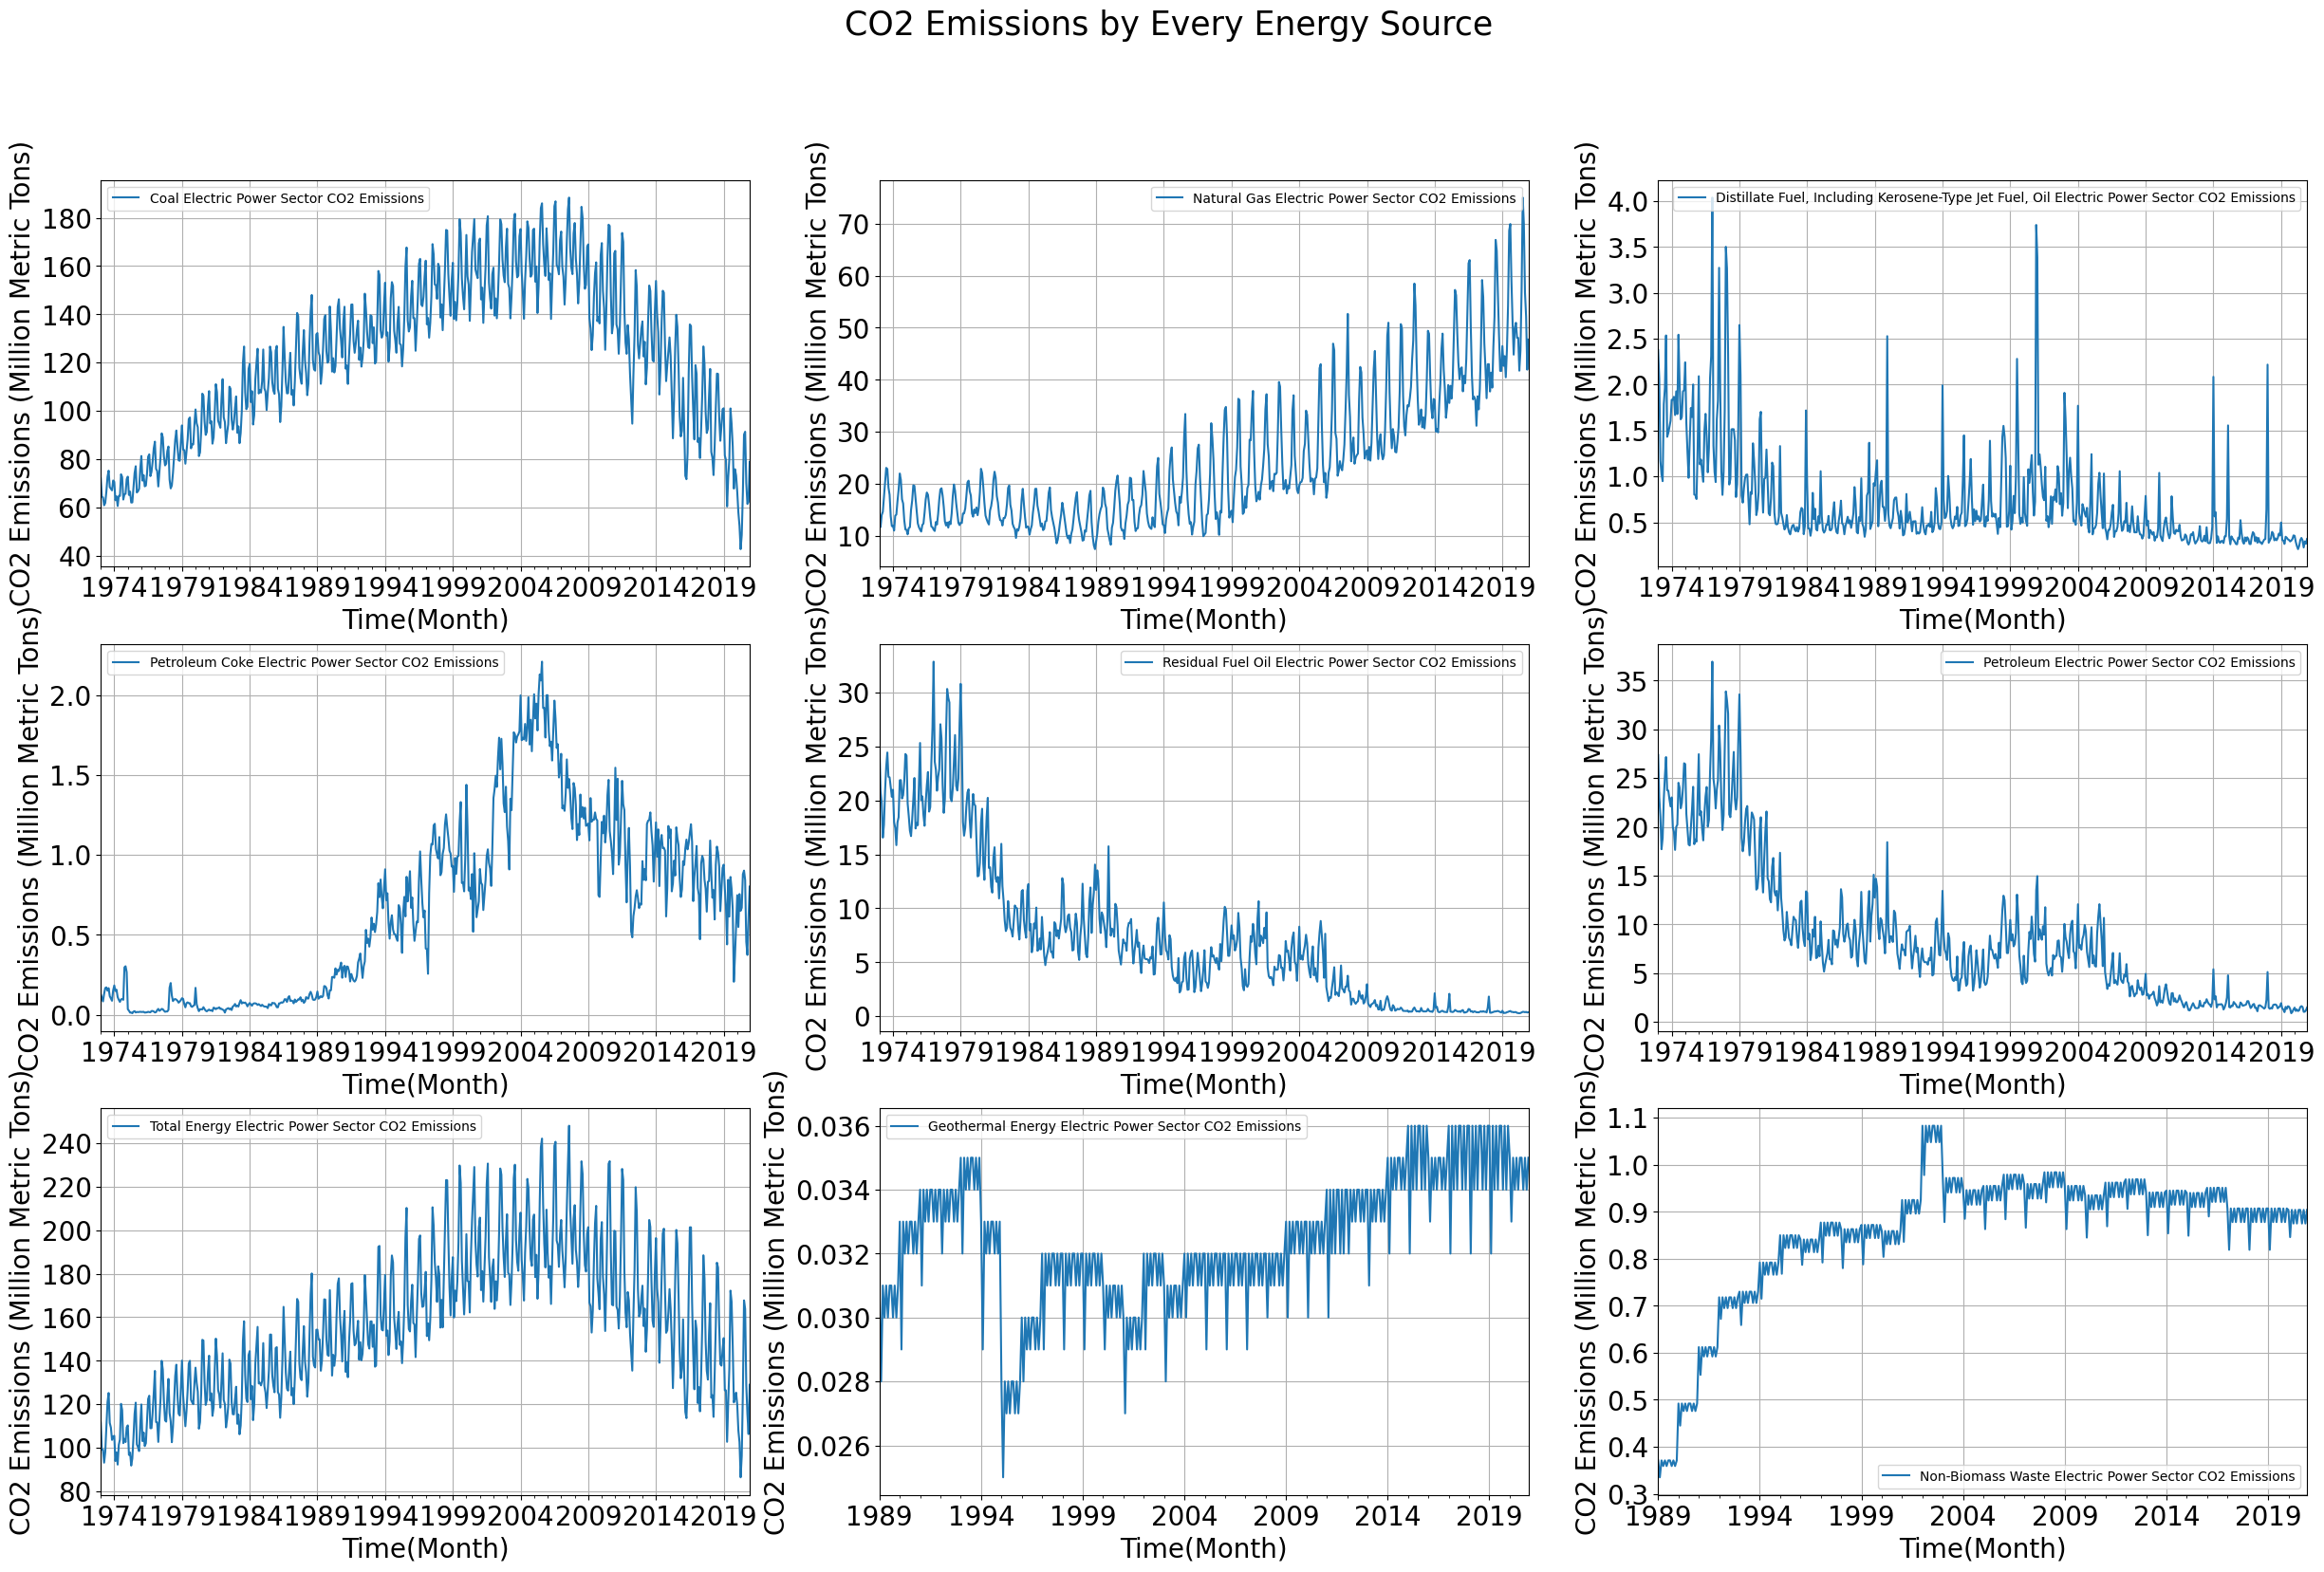

In [7]:
# 生成3*3子图
fig, ax = plt.subplots(3, 3, figsize = (30,18))
axes = ax.flatten()
fig.suptitle('CO2 Emissions by Every Energy Source', fontsize = 25)

# 画前7个
keys1 = df1.keys()
for key_index in range(len(keys1)):
    key = keys1[key_index]
    df[key].plot(ax = axes[key_index], fontsize = 20)
    
# 画后两个
keys2 = df2.keys()
for key_index in range(len(keys2)):
    key = keys2[key_index]
    axes_index = key_index + len(keys1)
    df2[key].plot(ax = axes[axes_index], fontsize = 20)
    
# 设置子图
for index in axes:
    index.set_xlabel('Time(Month)', fontsize = 20)
    index.set_ylabel('CO2 Emissions (Million Metric Tons)', fontsize = 20)
    index.legend(loc='best')
    index.grid()


绘制柱状图

In [8]:
# 求和排序
# co2 = df2['1989-01-01':].sum()
co2 = df2[:].sum()
print(co2)
print('#'*50)
co2 = co2.append(df1.loc['1989-01-01':].sum()) 
print(co2)
print('#'*50)
co2 = co2.sort_values()
print(co2)

Geothermal Energy Electric Power Sector CO2 Emissions     12.417
Non-Biomass Waste Electric Power Sector CO2 Emissions    328.774
dtype: float64
##################################################
Geothermal Energy Electric Power Sector CO2 Emissions                                            12.417
Non-Biomass Waste Electric Power Sector CO2 Emissions                                           328.774
Coal Electric Power Sector CO2 Emissions                                                      52428.046
Natural Gas Electric Power Sector CO2 Emissions                                               11083.977
Distillate Fuel, Including Kerosene-Type Jet Fuel, Oil Electric Power Sector CO2 Emissions      224.773
Petroleum Coke Electric Power Sector CO2 Emissions                                              366.577
Residual Fuel Oil Electric Power Sector CO2 Emissions                                          1390.720
Petroleum Electric Power Sector CO2 Emissions                               

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


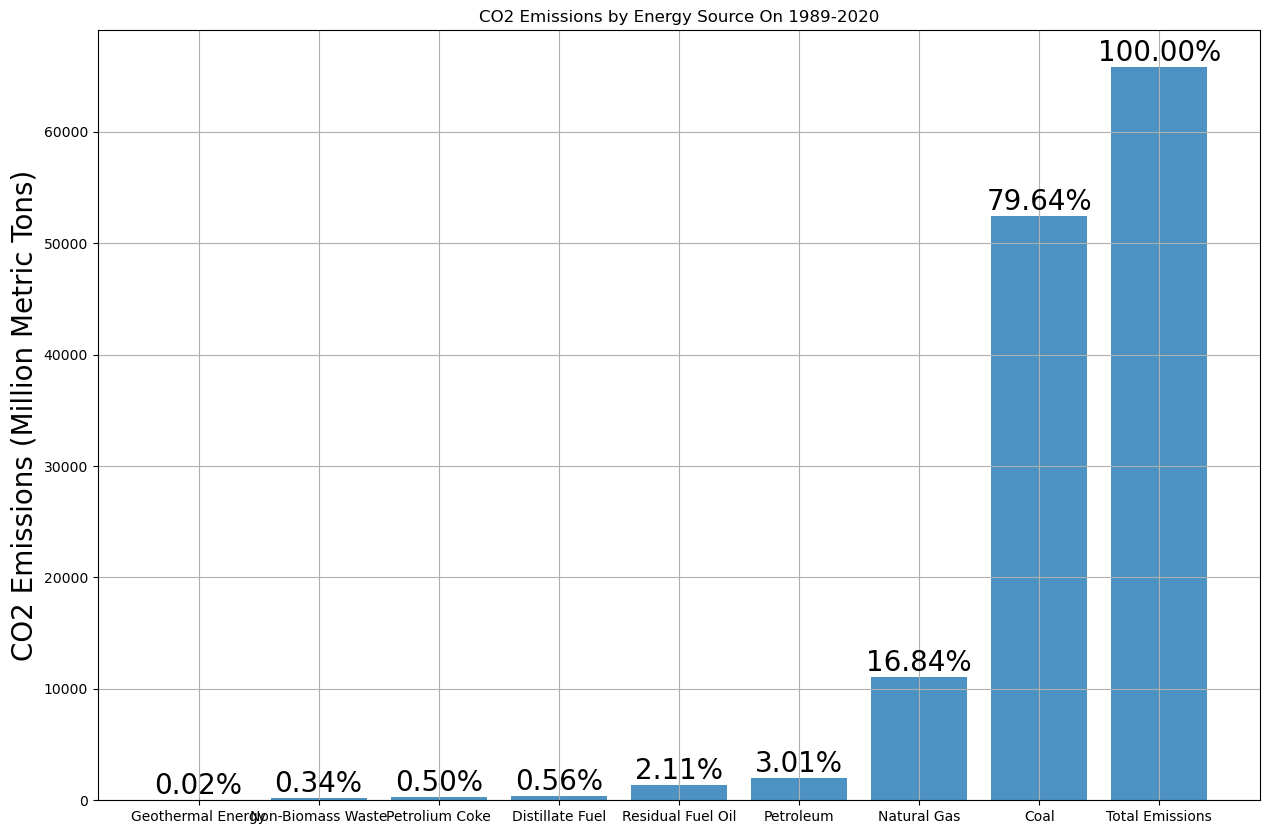

In [9]:
# 每种能源的CO2排放量柱状图
cols = ['Geothermal Energy', 'Non-Biomass Waste', 'Petrolium Coke', 'Distillate Fuel',
        'Residual Fuel Oil', 'Petroleum', 'Natural Gas', 'Coal', 'Total Emissions']
fig, ax = plt.subplots(figsize = (15, 10))
bar = ax.bar(cols, co2, align='center', alpha=0.8)
ax.bar_label(bar, labels=['%.2f%%' % (p*100) for p in co2/co2[-1]],fontsize=20)
ax.set_ylabel('CO2 Emissions (Million Metric Tons)', fontsize = 20)
ax.set_title('CO2 Emissions by Energy Source On 1989-2020')
ax.grid()

### 选择天然气发电CO2排放量

In [10]:
NGE = df1['Natural Gas Electric Power Sector CO2 Emissions']
NGE.head()

Month
1973-01-01    12.175
1973-02-01    11.708
1973-03-01    13.994
1973-04-01    14.627
1973-05-01    17.344
Name: Natural Gas Electric Power Sector CO2 Emissions, dtype: float64

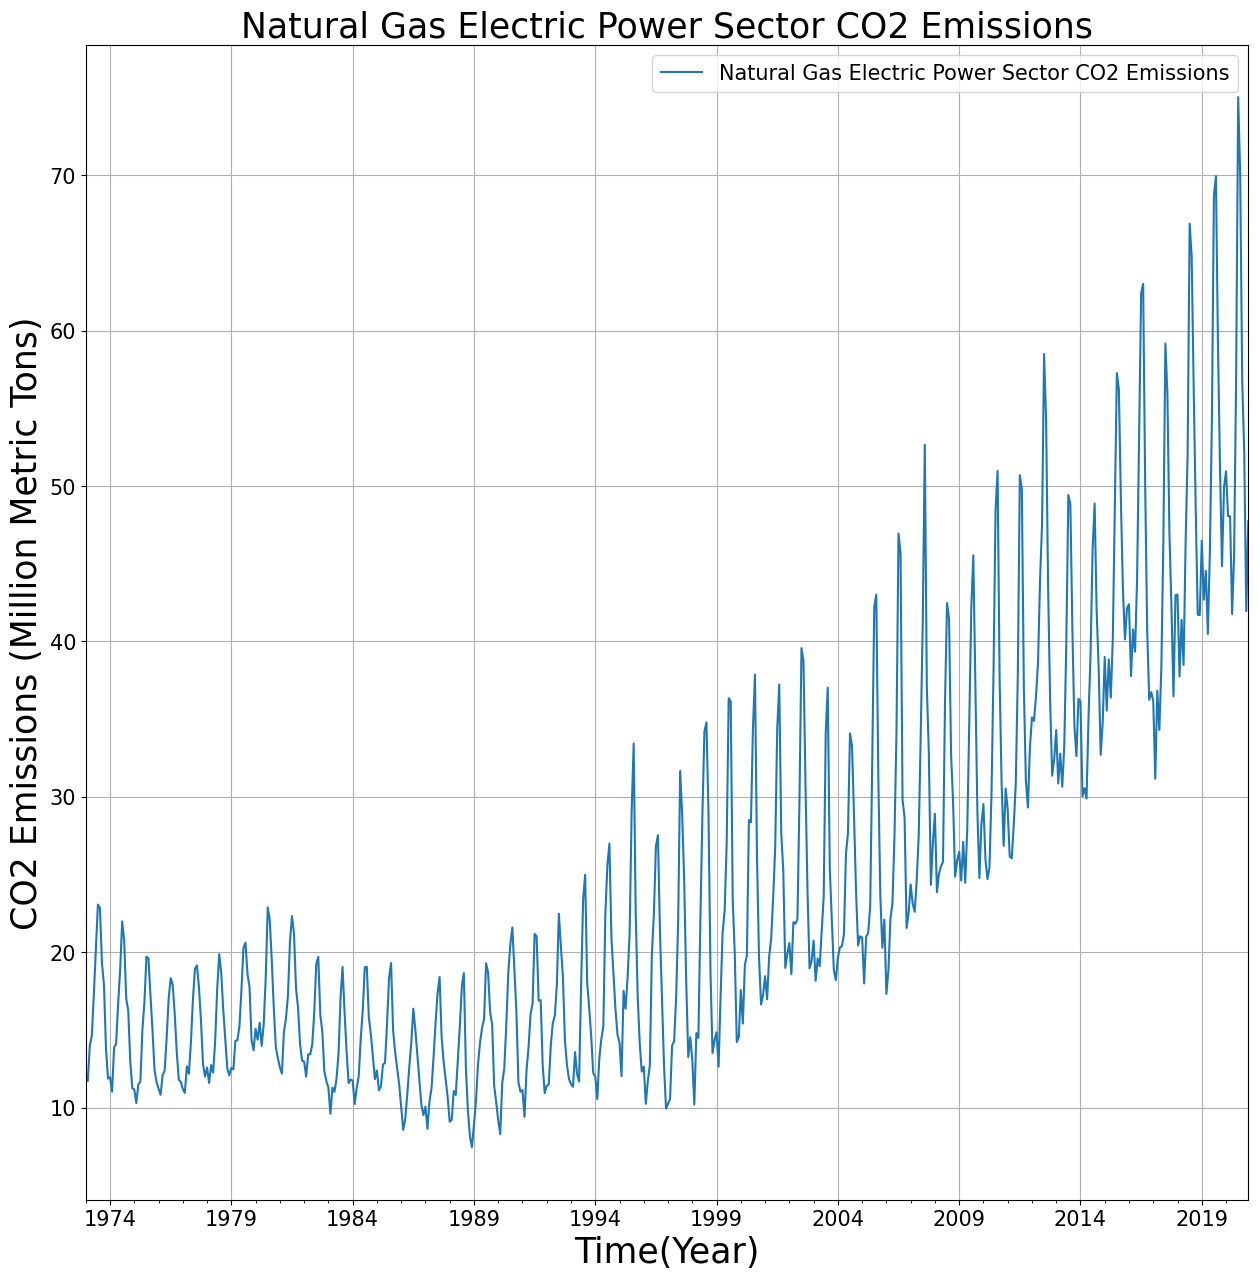

In [11]:
# 天然气CO2排放量折线图
fig, ax = plt.subplots(figsize = (15, 15))
NGE.plot(ax = ax, fontsize = 15)
ax.set_title('Natural Gas Electric Power Sector CO2 Emissions', fontsize = 25)
ax.set_xlabel('Time(Year)', fontsize = 25)
ax.set_ylabel('CO2 Emissions (Million Metric Tons)', fontsize = 25)
ax.legend(loc='best', fontsize = 15)
ax.grid()

### 分解时序

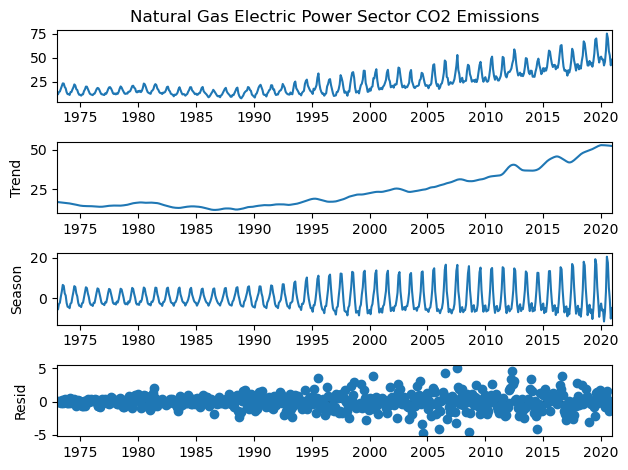

In [12]:
decomposition = tsa.STL(NGE).fit()
decomposition.plot()
# 趋势效应
trend = decomposition.trend
# 季节效应
seasonal = decomposition.seasonal
# 残差项
residual = decomposition.resid

### 平稳性检验——ADF检验

In [13]:
def test_stationarity(timeseries, alpha=1e-3):
    dftest = tsa.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        
    print(dfoutput)
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:
        print('X 是平稳的')
        return True
    else:
        print('X 是非平稳的')
        return False

In [14]:
test_stationarity(NGE)

Test Statistic                   1.199387
p-value                          0.995982
#Lags Used                      15.000000
Number of Observations Used    560.000000
Critical Value (1%)             -3.442081
Critical Value (5%)             -2.866715
Critical Value (10%)            -2.569526
dtype: float64
X 是非平稳的


False

### 序列平稳化

In [15]:
# 常查分
nge_difference = NGE.diff(1)
# 季节差分-12步
nge_seasonal = nge_difference.diff(12)

test_stationarity(nge_seasonal.dropna())

Test Statistic                -9.874391e+00
p-value                        3.917473e-17
#Lags Used                     1.200000e+01
Number of Observations Used    5.500000e+02
Critical Value (1%)           -3.442296e+00
Critical Value (5%)           -2.866809e+00
Critical Value (10%)          -2.569576e+00
dtype: float64
X 是平稳的


True

### 非白噪声检验

In [16]:
def test_white_noise(data):
    return sm.stats.acorr_ljungbox(data.dropna(), return_df=True) # 小于阈值则为非白噪声

In [17]:
test_white_noise(nge_seasonal)

,lb_stat,lb_pvalue
1,23.870831,1.030210e-06
2,49.820562,1.519156e-11
3,53.409396,1.499548e-11
4,53.468006,6.801155e-11
5,53.853807,2.245943e-10
6,53.858783,7.877041e-10
7,55.885971,9.949007e-10
8,55.896232,2.955186e-09
9,55.898658,8.207141e-09
10,68.636542,8.122986e-11


### 建立SARIMA模型

图解法定阶

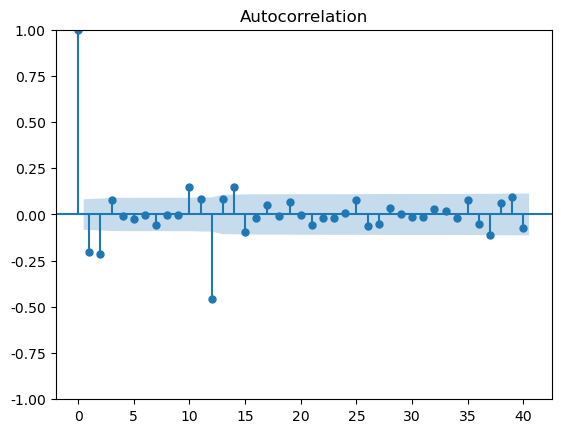

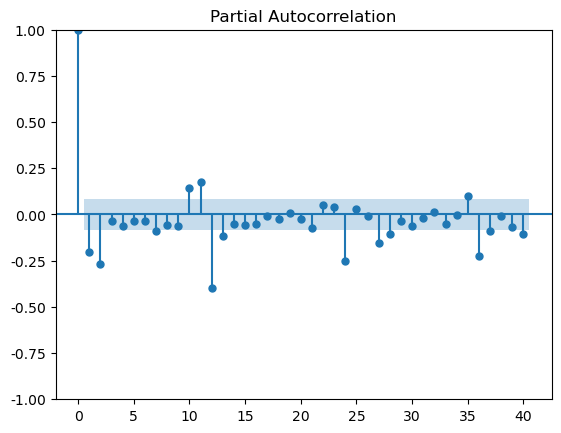

In [18]:
fig = plot_acf(nge_seasonal.dropna(), lags=40)
fig = plot_pacf(nge_seasonal.dropna(), lags=40)

网格搜索定阶

In [19]:
def grid_search(data):
    p = q = range(0, 3)
    s = [12]
    d = [1]
    PDQs = list(itertools.product(p, d, q, s))
    pdq = list(itertools.product(p, d, q))
    params = []
    seasonal_params = []
    results = []
    grid = pd.DataFrame()
    
    for param in pdq:
        for seasonal_param in PDQs:
            mod = tsa.SARIMAX(data, order=param, seasonal_order=seasonal_param, enforce_stationarity=False, enforce_invertibility=False)
            result = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, seasonal_param, result.aic))
            params.append(param)
            seasonal_params.append(seasonal_param)
            results.append(result.aic)
            
    grid['pdq'] = params
    grid['PDQs'] = seasonal_params
    grid['aic'] = results
    print(grid[grid['aic'] == min(grid['aic'])])

In [ ]:
grid_search(NGE)

建立模型


In [20]:
mod = tsa.SARIMAX(NGE, order=(1, 1, 2), seasonal_order=(0, 1, 2, 12))
results = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06272D+00    |proj g|=  1.28536D-01


 This problem is unconstrained.



At iterate    5    f=  2.02703D+00    |proj g|=  7.75792D-03

At iterate   10    f=  2.01360D+00    |proj g|=  4.89522D-02

At iterate   15    f=  2.00287D+00    |proj g|=  3.40421D-02

At iterate   20    f=  1.99872D+00    |proj g|=  4.31887D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     30      1     0     0   5.381D-06   1.999D+00
  F =   1.9987139859599925     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


残差项白噪声检验

In [21]:
test_white_noise(results.resid)

,lb_stat,lb_pvalue
1,0.183408,0.668461
2,0.235488,0.888924
3,1.269121,0.736478
4,1.395864,0.844914
5,1.397721,0.924562
6,1.414408,0.964976
7,2.795129,0.903286
8,4.053652,0.852251
9,4.656223,0.863188
10,7.237345,0.702864


画出图像

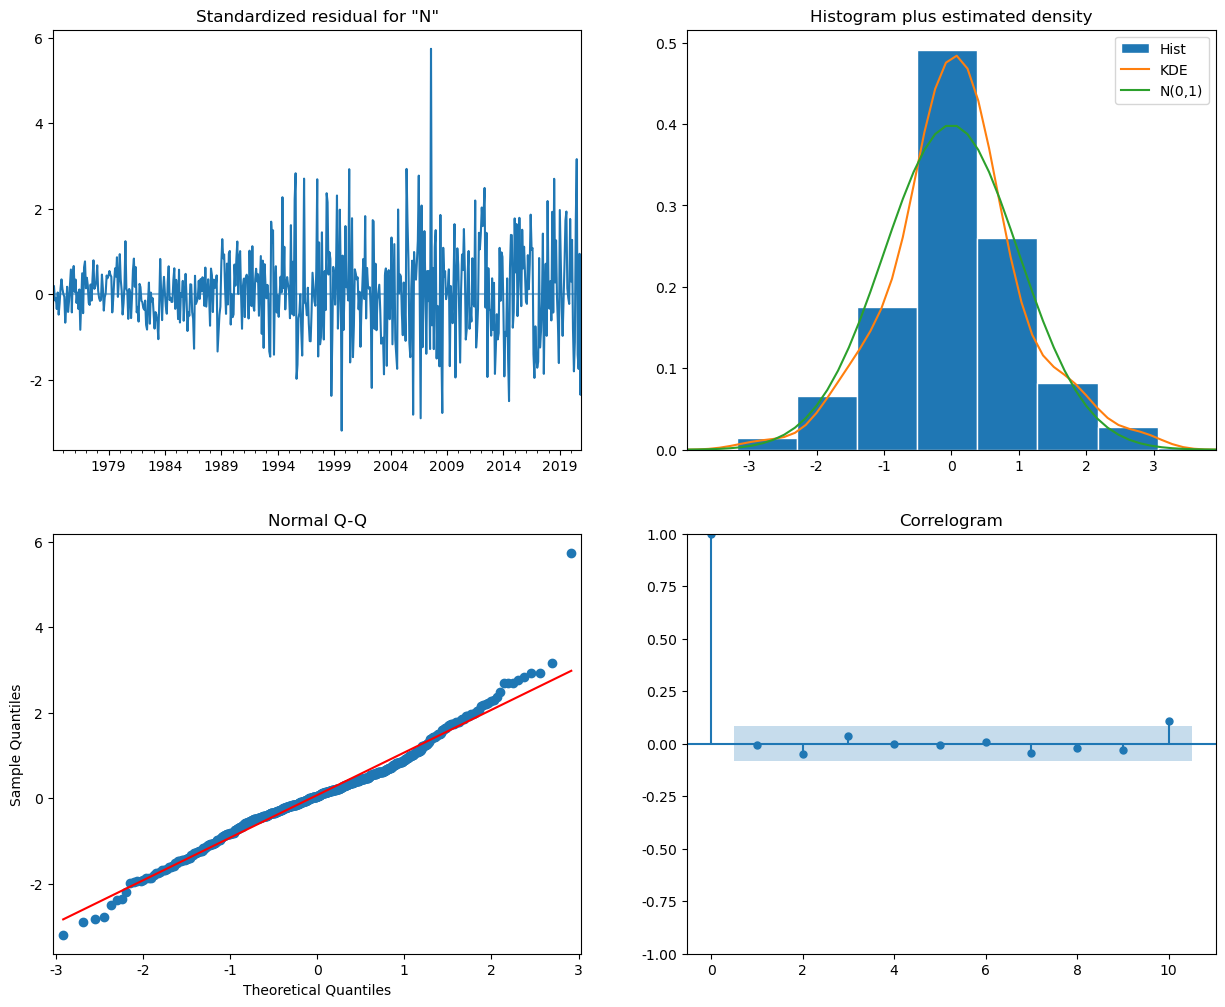

In [22]:
fig_result = results.plot_diagnostics(figsize=(15, 12))

### 模型预测、误差分析

In [23]:
def get_prediction(data, results, start, dynamic=False):
    pred = results.get_prediction(start=start, dynamic=dynamic, full_results=True)
    pred_ci = pred.conf_int()
    forecast = pred.predicted_mean
    truth = data[start:]
    pred_concat = pd.concat([truth, forecast, pred_ci], axis=1)
    pred_concat.columns = ['true', 'pred', 'up', 'low']
    print('MSE: ', mean_squared_error(truth, forecast))
    print('RMSE: ', np.sqrt(mean_squared_error(truth, forecast)))
    return pred_concat

# 绘制预测结果
def plot_prediction(pred_concat):
    plt.fill_between(pred_concat.index, pred_concat['up'], pred_concat['low'], alpha=0.4, label='pred_range')
    plt.plot(pred_concat['true'], label='true')
    plt.plot(pred_concat['pred'], label='pred')
    plt.legend()
    plt.show()
    

MSE:  5.458382845026255
RMSE:  2.336318224263607


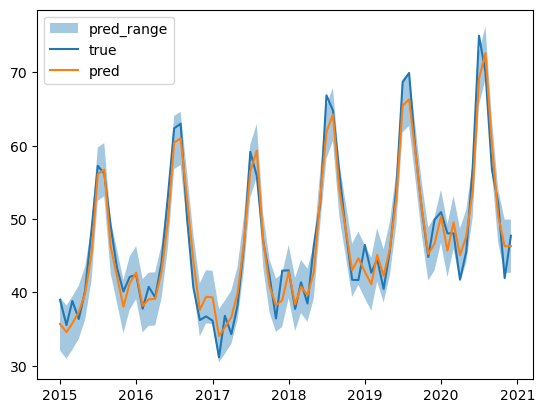

MSE:  41.221202091257986
RMSE:  6.4203739837534375


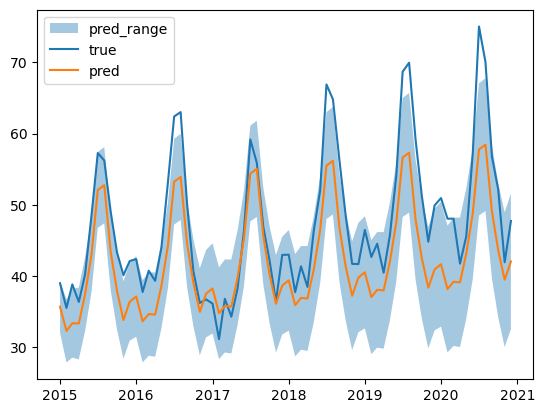

In [24]:
# 静态预测-进行一系列的一步预测，即它必须用真实值来进行预测
pred = get_prediction(NGE, results, '2015-01-01')
plot_prediction(pred)

# 动态预测-除了第一个预测值是用实际值预测外，其后各预测值都是采用递推预测
pred = get_prediction(NGE, results, '2015-01-01', dynamic=True)
plot_prediction(pred)

未来预测

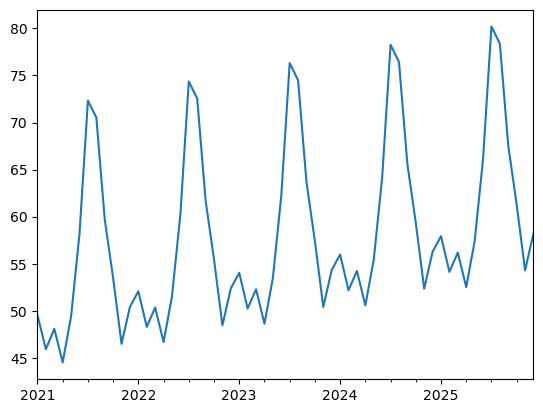

In [25]:
forecast = results.get_forecast(steps=60)
fig = forecast.predicted_mean.plot()

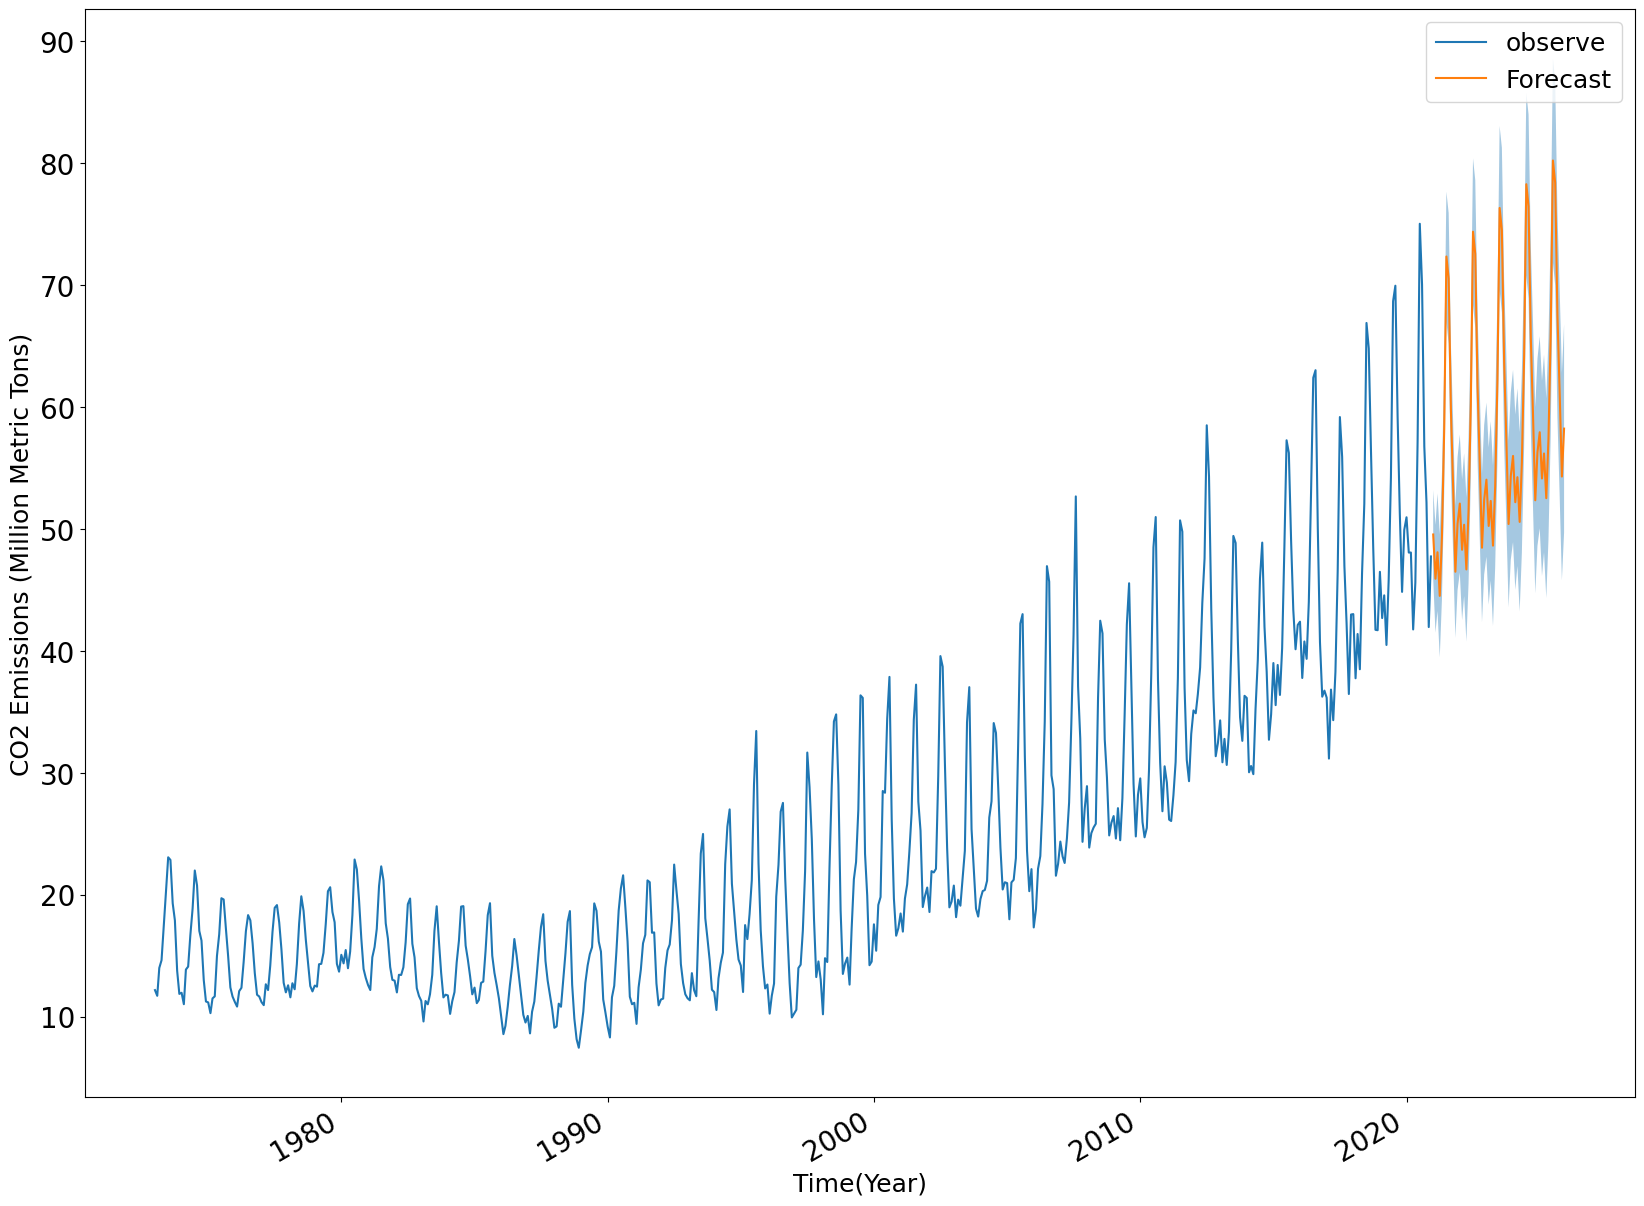

In [26]:
# 展示最终预测：原始序列、预测序列、置信区间
fig, ax = plt.subplots(figsize=(20,16))
ax.plot(NGE, label='observe')
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast.conf_int().index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], alpha=0.4)
ax.set_xlabel('Time(Year)', fontsize=18)
ax.set_ylabel('CO2 Emissions (Million Metric Tons)', fontsize=18)
ax.legend(loc='best', fontsize=18)
plt.xticks(fontsize=20) # 设置刻度标签字体大小
plt.yticks(fontsize=20)
plt.show()